In [286]:
import dlc_practical_prologue as prologue
import torch
from torch import  nn
from torch.nn import functional as F
import math
from torch import optim
from torch import Tensor
from torch import nn
import matplotlib.pyplot as plt
import math

In [10]:
train_input, train_target, train_classes, test_input, test_target, test_classes = prologue.generate_pair_sets(1000)

In [11]:
IMAGE_SIZE = 196
NUM_CLASSES = 10

In [40]:
train_input_1 = train_input[:, 0, :, :]
train_input_2 = train_input[:, 1, :, :]
test_input_1 = test_input[:, 0, :, :]
test_input_2 = test_input[:, 1, :, :]
train_classes_1 = train_classes[:, 0]
train_classes_2 = train_classes[:, 1]
test_classes_1 = test_classes[:, 0]
test_classes_2 = test_classes[:, 1]


In [13]:
class ShallowFullyConncectedNet(nn.Module):
    def __init__(self, nb_hidden):
        super(ShallowFullyConncectedNet, self).__init__()
        self.fc1 = nn.Linear(IMAGE_SIZE, nb_hidden)
        self.fc2 = nn.Linear(nb_hidden, NUM_CLASSES)
        self.name = f"ShallowFullyConncectedNet({nb_hidden})"

    def forward(self, x):
        x = F.relu(self.fc1(x.view(-1, IMAGE_SIZE)))
        x = self.fc2(x)
        return x

In [14]:
class DeepFullyConncectedNet(nn.Module):
    def __init__(self, nb_layers):
        super(DeepFullyConncectedNet, self).__init__()
        self.layers = nn.ModuleList([])
        self.name = f"DeepFullyConncectedNet({nb_layers})"
        acc = IMAGE_SIZE
        if nb_layers % 2 !=0:
            nb_layers = nb_layers - 1
        for l in range(nb_layers):
            if l < nb_layers/2:
                self.layers.append(nn.Linear(acc, acc*2))
                acc = acc*2
            else:
                self.layers.append(nn.Linear(acc, int(acc/2)))
                acc = int(acc/2)
        self.layers.append(nn.Linear(IMAGE_SIZE, 10))

        

    def forward(self, x):
        acc = IMAGE_SIZE
        for l in range(len(self.layers)-1):
            x = F.relu(self.layers[l](x.view(-1, acc)))
            if l < (len(self.layers)-1)/2:
                acc = acc*2
            else:
                acc = int(acc/2)
        x = self.layers[len(self.layers)-1](x)

       
        return x

In [15]:
class BasicCNN(nn.Module):
    def __init__(self, nb_hidden):
        super(BasicCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.fc1 = nn.Linear(256, nb_hidden)
        self.fc2 = nn.Linear(nb_hidden, 10)
        self.name = f"BasicCNN({nb_hidden})"

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x.view(-1, 1, 14, 14)), kernel_size=2, stride=2))
        x = F.relu(F.max_pool2d(self.conv2(x), kernel_size=2, stride=2))
        x = F.relu(self.fc1(x.view(-1, 256)))
        x = self.fc2(x)
        return x

In [16]:
# TODO 
# class ResNetBlock(nn.Module):
#     def __init__(self, nb_channels, kernel_size,
#                  skip_connections = True, batch_normalization = True):
#         super(ResNetBlock, self).__init__()

#         self.conv1 = nn.Conv2d(nb_channels, nb_channels,
#                                kernel_size = kernel_size,
#                                padding = (kernel_size - 1) // 2)

#         self.bn1 = nn.BatchNorm2d(nb_channels)

#         self.conv2 = nn.Conv2d(nb_channels, nb_channels,
#                                kernel_size = kernel_size,
#                                padding = (kernel_size - 1) // 2)

#         self.bn2 = nn.BatchNorm2d(nb_channels)

#         self.skip_connections = skip_connections
#         self.batch_normalization = batch_normalization
        

#     def forward(self, x):
#         y = self.conv1(x)
#         if self.batch_normalization: y = self.bn1(y)
#         y = F.relu(y)
#         y = self.conv2(y)
#         if self.batch_normalization: y = self.bn2(y)
#         if self.skip_connections: y = y + x
#         y = F.relu(y)

#         return y
    

# class ResNet(nn.Module):

#     def __init__(self, nb_residual_blocks, nb_channels,
#                  kernel_size = 3, nb_classes = 10,
#                  skip_connections = True, batch_normalization = True):
#         super(ResNet, self).__init__()

#         self.conv = nn.Conv2d(3, nb_channels,
#                               kernel_size = kernel_size,
#                               padding = (kernel_size - 1) // 2)
#         self.bn = nn.BatchNorm2d(nb_channels)

#         self.resnet_blocks = nn.Sequential(
#             *(ResNetBlock(nb_channels, kernel_size, skip_connections, batch_normalization)
#               for _ in range(nb_residual_blocks))
#         )

#         self.fc = nn.Linear(nb_channels, nb_classes)

#     def forward(self, x):
#         x = F.relu(self.bn(self.conv(x)))
#         x = self.resnet_blocks(x)
#         x = F.avg_pool2d(x, 32).view(x.size(0), -1)
#         x = self.fc(x)
#         return x


In [325]:
def train_model(model, train_input, train_target, mini_batch_size, eta, criterion = nn.CrossEntropyLoss(), nb_epochs = 25):
    accuracy = []
    optimizer = optim.SGD(model.parameters(), eta)
    for e in range(nb_epochs):
        running_loss = 0
        running_accuracy = 0
        for b in range(0, train_input.size(0), mini_batch_size):
            output = model(train_input.narrow(0, b, mini_batch_size))
            loss = criterion(output, train_target.narrow(0, b, mini_batch_size))
            model.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            running_accuracy += compute_nb_correct_digit(output, b, train_target, mini_batch_size)
            
        # print loss statistics
        print('[%d] loss: %.3f' % (e + 1, running_loss / math.ceil(train_input.size(0) / mini_batch_size)))
              
        # compute accuracy
        accuracy.append(running_accuracy / train_input.size(0))
    return accuracy

In [326]:
def compute_nb_correct_digit(output, b, target, mini_batch_size):
    nb_corrects = 0
    _, predicted_classes = output.max(1)
    for k in range(mini_batch_size):
        if target[b + k] == predicted_classes[k]:
            nb_corrects += 1
    return nb_corrects 

In [331]:
def compute_percentage_project_error(model, input1, input2, target, mini_batch_size):
    nb_errors = 0
    for b in range(0, input1.size(0), mini_batch_size):
        output1 = model(input1.narrow(0, b, mini_batch_size))
        output2 = model(input2.narrow(0, b, mini_batch_size))
        _, predicted_classes1 = output1.max(1)
        _, predicted_classes2 = output2.max(1)
        for k in range(mini_batch_size):
            if target[b + k] != (predicted_classes1[k] <= predicted_classes2[k]):
                nb_errors = nb_errors + 1

    return nb_errors / target.size(0) * 100

In [332]:
def plot_accuracy(accuracy, epochs):
    x = [epoch for epoch in range(1, epochs + 1)]
    plt.plot(x, accuracy, color='green')
    plt.xlabel('Number of epoch')
    plt.ylabel('Digit acuuracy')
    plt.title('Train accuracy in function of the epoch')
    plt.show()

In [333]:
def train_test(model, mini_batch_size, eta, criterion, nb_epochs):
    train = torch.cat((train_input_1, train_input_2), 0)
    target = torch.cat((train_classes_1, train_classes_2), 0)

    accuracy = train_model(model, train, target, mini_batch_size, eta, criterion, nb_epochs)
    plot_accuracy(accuracy, nb_epochs)
    train_error = compute_percentage_project_error(model, train_input_1, train_input_2, train_target, mini_batch_size) 
    test_error = compute_percentage_project_error(model, test_input_1, test_input_2, test_target, mini_batch_size) 
    print(f'MODEL: {model.name}, BATCH_SIZE: { mini_batch_size}, CRITERION: {str(criterion)}, EPOCHS: {nb_epochs}, train_error:{train_error}%, test_error: {test_error}%')

[1] loss: 142213.312
[2] loss: 2.841
[3] loss: 2.234
[4] loss: 2.234
[5] loss: 2.252
[6] loss: 2.294
[7] loss: 2.244
[8] loss: 2.243
[9] loss: 2.238
[10] loss: 2.245
[11] loss: 2.244
[12] loss: 2.244
[13] loss: 2.244
[14] loss: 2.244
[15] loss: 2.244
[16] loss: 2.244
[17] loss: 2.244
[18] loss: 2.244
[19] loss: 2.244
[20] loss: 2.244
[21] loss: 2.244
[22] loss: 2.244
[23] loss: 2.244
[24] loss: 2.244
[25] loss: 2.244


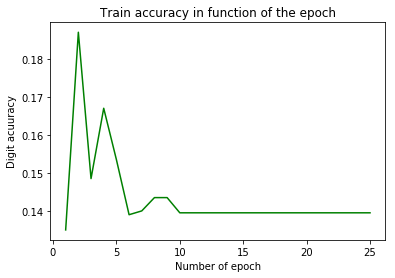

MODEL: ShallowFullyConncectedNet(1000), BATCH_SIZE: 100, CRITERION: CrossEntropyLoss(), EPOCHS: 25, train_error:21.75%, test_error: 23.0%


In [334]:
train_test(ShallowFullyConncectedNet(1000), mini_batch_size=100, eta = 1e-1, criterion =nn.CrossEntropyLoss(), nb_epochs = 25)

[1] loss: 0.426
[2] loss: 0.338
[3] loss: 0.301
[4] loss: 0.172
[5] loss: 0.120
[6] loss: 0.064
[7] loss: 0.052
[8] loss: 0.084
[9] loss: 0.044
[10] loss: 0.017
[11] loss: 0.154
[12] loss: 0.144
[13] loss: 0.087
[14] loss: 0.039
[15] loss: 0.014
[16] loss: 0.008
[17] loss: 0.005
[18] loss: 0.018
[19] loss: 0.003
[20] loss: 0.002
[21] loss: 0.002
[22] loss: 0.001
[23] loss: 0.001
[24] loss: 0.001
[25] loss: 0.001


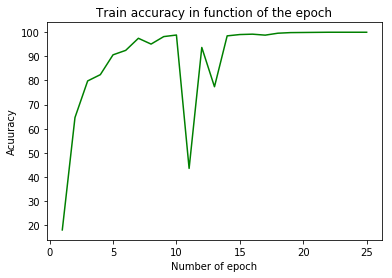

MODEL: DeepFullyConncectedNet(7), BATCH_SIZE: 100, CRITERION: CrossEntropyLoss(), EPOCHS: 25, train_error:99.9%, test_error: 4.79%


In [211]:
train_test(DeepFullyConncectedNet(7), 100, eta = 1e-1, criterion =nn.CrossEntropyLoss(), nb_epochs = 25)

In [37]:
train_test(BasicCNN(100), 100, eta = 1e-1, criterion =nn.CrossEntropyLoss(), nb_epochs = 25)

[1] loss: 2397556.622
[2] loss: 0.461
[3] loss: 0.460
[4] loss: 0.460
[5] loss: 0.460
[6] loss: 0.460
[7] loss: 0.460
[8] loss: 0.460
[9] loss: 0.460
[10] loss: 0.460
[11] loss: 0.460
[12] loss: 0.460
[13] loss: 0.460
[14] loss: 0.460
[15] loss: 0.460
[16] loss: 0.460
[17] loss: 0.460
[18] loss: 0.460
[19] loss: 0.460
[20] loss: 0.460
[21] loss: 0.460
[22] loss: 0.460
[23] loss: 0.460
[24] loss: 0.460
[25] loss: 0.460
MODEL: BasicCNN(100), BATCH_SIZE: 100, CRITERION: CrossEntropyLoss(), EPOCHS: 25, train_error:45.2%, test_error: 47.599999999999994%


In [23]:
BasicCNN(100)

BasicCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=10, bias=True)
)

In [24]:
train_input_1.view(-1, 1, 14, 14).shape

torch.Size([1000, 1, 14, 14])

In [25]:
DeepFullyConncectedNet(7)

DeepFullyConncectedNet(
  (layers): ModuleList(
    (0): Linear(in_features=196, out_features=392, bias=True)
    (1): Linear(in_features=392, out_features=784, bias=True)
    (2): Linear(in_features=784, out_features=1568, bias=True)
    (3): Linear(in_features=1568, out_features=784, bias=True)
    (4): Linear(in_features=784, out_features=392, bias=True)
    (5): Linear(in_features=392, out_features=196, bias=True)
    (6): Linear(in_features=196, out_features=10, bias=True)
  )
)